## **Mini Project 3: Done by Rahma Nouaji, Mohammad Ghavidel, Bita Farokhian**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


print(tf.__version__)

2.12.0


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Apr 25 13:15:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# GANS on MNIST dataset

In [ ]:
from keras.datasets import mnist
import cv2
from keras.layers import Input, Dense, Dropout,Flatten, Reshape, LeakyReLU, BatchNormalization
from keras.models import Model, Sequential
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
#import shutil

In [ ]:

# example of loading the mnist dataset
from keras.datasets.mnist import load_data
from matplotlib import pyplot
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# plot images from the training dataset
for i in range(25):
 # define subplot
 pyplot.subplot(5, 5, 1 + i)
 # turn off axis
 pyplot.axis('off')
 # plot raw pixel data
 pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()

GAN three  

In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
import random
from numpy.random import normal
from keras.losses import MeanSquaredError

from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

In [ ]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:



# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y


In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y


In [ ]:

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)

In [ ]:


# train the generator and discriminator
def train1(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):

	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    d_losses, g_losses = [], []  # initialize lists to record losses

    for i in range(n_epochs):
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)

            d_losses.append(d_loss)  # record the discriminator loss
            g_losses.append(g_loss)  # record the generator loss

            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

        # summarize loss on this epoch
        print('>> Epoch %d: Discriminator loss=%.3f, Generator loss=%.3f' % (i+1, np.mean(d_losses[-bat_per_epo:]), np.mean(g_losses[-bat_per_epo:])))

        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

    # plot the discriminator and generator losses over the epochs
    plt.plot(d_losses, label='Discriminator')
    plt.plot(g_losses, label='Generator')
    plt.title('Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


## Training GANs

In [ ]:

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim,n_batch=256)

In [ ]:
from tensorflow.keras.models import load_model


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_g_model = load_model('generator_model_100.h5')
# ##This to continue training
# train(loaded_g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50)

In [ ]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


# def generate_latent_points(latent_dim, n_samples):
#     x_input = normal(0, 0.2, size=(n_samples, latent_dim))
#     return x_input


# create and save a plot of generated images (reversed grayscale)
def save_plot_eval(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

# # load model
model = load_model('generator_model_100.h5')
# # generate images
latent_points = generate_latent_points(100, 100)
# # generate images
X = model.predict(latent_points)
# # plot the result
save_plot_eval(X, 10)

In [ ]:
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
# load model
model = load_model('generator_model_100.h5')
# all 0s
vector = asarray([[0.0 for _ in range(100)]])
# generate image
X = model.predict(vector)
# plot the result
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()

#Ablation Study:

In [ ]:
def save_plot_perbatch(examples,batch_size, n):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    # save plot to file
    if batch_size==64:
        filename = 'results/generated_plot64_e050.png'
        pyplot.savefig(filename)
        pyplot.close()
    elif batch_size==128:
        filename = 'results/generated_plot128_e050.png'
        pyplot.savefig(filename)
        pyplot.close()
    else:
        filename = 'results/generated_plot256_e050.png'
        pyplot.savefig(filename)
        pyplot.close()


#### Different batch sizes

In [ ]:
%mkdir results

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
2/2 [==============================] - 0s 4ms/step
>5, 313/468, d=0.686, g=0.732
2/2 [==============================] - 0s 4ms/step
>5, 314/468, d=0.695, g=0.732
2/2 [==============================] - 0s 4ms/step
>5, 315/468, d=0.691, g=0.720
2/2 [==============================] - 0s 4ms/step
>5, 316/468, d=0.682, g=0.699
2/2 [==============================] - 0s 4ms/step
>5, 317/468, d=0.693, g=0.685
2/2 [==============================] - 0s 4ms/step
>5, 318/468, d=0.693, g=0.686
2/2 [==============================] - 0s 4ms/step
>5, 319/468, d=0.694, g=0.683
2/2 [==============================] - 0s 4ms/step
>5, 320/468, d=0.700, g=0.674
2/2 [==============================] - 0s 3ms/step
>5, 321/468, d=0.686, g=0.684
2/2 [==============================] - 0s 8ms/step
>5, 322/468, d=0.697, g=0.682
2/2 [==============================] - 0s 3ms/step
>5, 323/468, d=0.700, g=0.680
2/2 [==========================

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
2/2 [==============================] - 0s 4ms/step
>15, 313/468, d=0.673, g=0.693
2/2 [==============================] - 0s 4ms/step
>15, 314/468, d=0.688, g=0.716
2/2 [==============================] - 0s 4ms/step
>15, 315/468, d=0.696, g=0.714
2/2 [==============================] - 0s 5ms/step
>15, 316/468, d=0.700, g=0.674
2/2 [==============================] - 0s 4ms/step
>15, 317/468, d=0.684, g=0.666
2/2 [==============================] - 0s 4ms/step
>15, 318/468, d=0.678, g=0.666
2/2 [==============================] - 0s 4ms/step
>15, 319/468, d=0.689, g=0.701
2/2 [==============================] - 0s 7ms/step
>15, 320/468, d=0.692, g=0.724
2/2 [==============================] - 0s 4ms/step
>15, 321/468, d=0.688, g=0.762
2/2 [==============================] - 0s 5ms/step
>15, 322/468, d=0.680, g=0.772
2/2 [==============================] - 0s 8ms/step
>15, 323/468, d=0.685, g=0.724
2/2 [===============

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
2/2 [==============================] - 0s 5ms/step
>25, 313/468, d=0.685, g=0.716
2/2 [==============================] - 0s 6ms/step
>25, 314/468, d=0.688, g=0.691
2/2 [==============================] - 0s 4ms/step
>25, 315/468, d=0.683, g=0.698
2/2 [==============================] - 0s 4ms/step
>25, 316/468, d=0.696, g=0.713
2/2 [==============================] - 0s 4ms/step
>25, 317/468, d=0.672, g=0.735
2/2 [==============================] - 0s 8ms/step
>25, 318/468, d=0.686, g=0.730
2/2 [==============================] - 0s 4ms/step
>25, 319/468, d=0.694, g=0.722
2/2 [==============================] - 0s 4ms/step
>25, 320/468, d=0.699, g=0.719
2/2 [==============================] - 0s 4ms/step
>25, 321/468, d=0.689, g=0.700
2/2 [==============================] - 0s 4ms/step
>25, 322/468, d=0.689, g=0.701
2/2 [==============================] - 0s 4ms/step
>25, 323/468, d=0.680, g=0.685
2/2 [===============

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
2/2 [==============================] - 0s 4ms/step
>35, 313/468, d=0.689, g=0.694
2/2 [==============================] - 0s 3ms/step
>35, 314/468, d=0.696, g=0.685
2/2 [==============================] - 0s 4ms/step
>35, 315/468, d=0.680, g=0.686
2/2 [==============================] - 0s 3ms/step
>35, 316/468, d=0.684, g=0.728
2/2 [==============================] - 0s 3ms/step
>35, 317/468, d=0.696, g=0.731
2/2 [==============================] - 0s 3ms/step
>35, 318/468, d=0.702, g=0.715
2/2 [==============================] - 0s 3ms/step
>35, 319/468, d=0.698, g=0.713
2/2 [==============================] - 0s 3ms/step
>35, 320/468, d=0.692, g=0.695
2/2 [==============================] - 0s 4ms/step
>35, 321/468, d=0.682, g=0.680
2/2 [==============================] - 0s 3ms/step
>35, 322/468, d=0.689, g=0.731
2/2 [==============================] - 0s 3ms/step
>35, 323/468, d=0.687, g=0.741
2/2 [===============

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
2/2 [==============================] - 0s 4ms/step
>45, 313/468, d=0.695, g=0.702
2/2 [==============================] - 0s 4ms/step
>45, 314/468, d=0.692, g=0.706
2/2 [==============================] - 0s 4ms/step
>45, 315/468, d=0.690, g=0.677
2/2 [==============================] - 0s 4ms/step
>45, 316/468, d=0.699, g=0.666
2/2 [==============================] - 0s 3ms/step
>45, 317/468, d=0.697, g=0.693
2/2 [==============================] - 0s 8ms/step
>45, 318/468, d=0.686, g=0.697
2/2 [==============================] - 0s 5ms/step
>45, 319/468, d=0.707, g=0.716
2/2 [==============================] - 0s 3ms/step
>45, 320/468, d=0.676, g=0.706
2/2 [==============================] - 0s 3ms/step
>45, 321/468, d=0.697, g=0.702
2/2 [==============================] - 0s 4ms/step
>45, 322/468, d=0.692, g=0.709
2/2 [==============================] - 0s 4ms/step
>45, 323/468, d=0.683, g=0.742
2/2 [===============

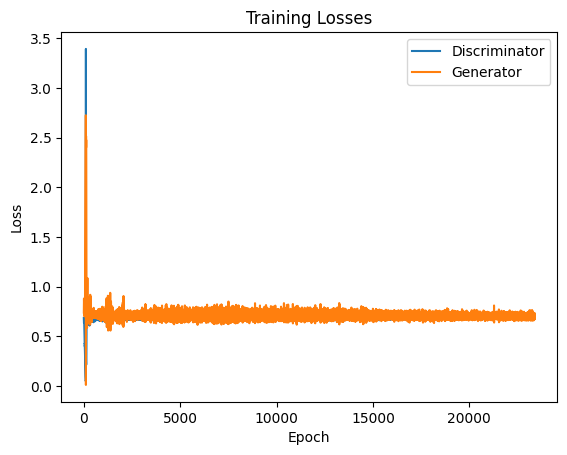

4/4 [==============================] - 0s 5ms/step
>1, 1/234, d=0.685, g=0.728
4/4 [==============================] - 0s 3ms/step
>1, 2/234, d=0.673, g=0.746
4/4 [==============================] - 0s 3ms/step
>1, 3/234, d=0.664, g=0.768
4/4 [==============================] - 0s 4ms/step
>1, 4/234, d=0.657, g=0.789
4/4 [==============================] - 0s 3ms/step
>1, 5/234, d=0.650, g=0.807
4/4 [==============================] - 0s 3ms/step
>1, 6/234, d=0.644, g=0.829
4/4 [==============================] - 0s 3ms/step
>1, 7/234, d=0.633, g=0.846
4/4 [==============================] - 0s 3ms/step
>1, 8/234, d=0.628, g=0.856
4/4 [==============================] - 0s 3ms/step
>1, 9/234, d=0.625, g=0.867
4/4 [==============================] - 0s 3ms/step
>1, 10/234, d=0.623, g=0.871
4/4 [==============================] - 0s 3ms/step
>1, 11/234, d=0.620, g=0.863
4/4 [==============================] - 0s 3ms/step
>1, 12/234, d=0.625, g=0.840
4/4 [==============================] - 0s 3ms/ste

4/4 [==============================] - 0s 6ms/step
>11, 1/234, d=0.687, g=0.709
4/4 [==============================] - 0s 4ms/step
>11, 2/234, d=0.697, g=0.702
4/4 [==============================] - 0s 4ms/step
>11, 3/234, d=0.693, g=0.700
4/4 [==============================] - 0s 3ms/step
>11, 4/234, d=0.690, g=0.703
4/4 [==============================] - 0s 3ms/step
>11, 5/234, d=0.685, g=0.715
4/4 [==============================] - 0s 3ms/step
>11, 6/234, d=0.689, g=0.715
4/4 [==============================] - 0s 3ms/step
>11, 7/234, d=0.685, g=0.715
4/4 [==============================] - 0s 3ms/step
>11, 8/234, d=0.685, g=0.709
4/4 [==============================] - 0s 3ms/step
>11, 9/234, d=0.689, g=0.712
4/4 [==============================] - 0s 3ms/step
>11, 10/234, d=0.681, g=0.714
4/4 [==============================] - 0s 3ms/step
>11, 11/234, d=0.682, g=0.718
4/4 [==============================] - 0s 4ms/step
>11, 12/234, d=0.683, g=0.716
4/4 [==============================] 

4/4 [==============================] - 0s 5ms/step
>21, 1/234, d=0.674, g=0.718
4/4 [==============================] - 0s 5ms/step
>21, 2/234, d=0.687, g=0.703
4/4 [==============================] - 0s 4ms/step
>21, 3/234, d=0.678, g=0.704
4/4 [==============================] - 0s 4ms/step
>21, 4/234, d=0.695, g=0.698
4/4 [==============================] - 0s 3ms/step
>21, 5/234, d=0.680, g=0.681
4/4 [==============================] - 0s 3ms/step
>21, 6/234, d=0.680, g=0.695
4/4 [==============================] - 0s 3ms/step
>21, 7/234, d=0.677, g=0.696
4/4 [==============================] - 0s 3ms/step
>21, 8/234, d=0.685, g=0.687
4/4 [==============================] - 0s 4ms/step
>21, 9/234, d=0.694, g=0.709
4/4 [==============================] - 0s 4ms/step
>21, 10/234, d=0.690, g=0.728
4/4 [==============================] - 0s 3ms/step
>21, 11/234, d=0.703, g=0.733
4/4 [==============================] - 0s 3ms/step
>21, 12/234, d=0.697, g=0.704
4/4 [==============================] 

4/4 [==============================] - 0s 5ms/step
>31, 1/234, d=0.695, g=0.727
4/4 [==============================] - 0s 5ms/step
>31, 2/234, d=0.681, g=0.701
4/4 [==============================] - 0s 5ms/step
>31, 3/234, d=0.678, g=0.675
4/4 [==============================] - 0s 4ms/step
>31, 4/234, d=0.688, g=0.667
4/4 [==============================] - 0s 5ms/step
>31, 5/234, d=0.685, g=0.676
4/4 [==============================] - 0s 3ms/step
>31, 6/234, d=0.685, g=0.699
4/4 [==============================] - 0s 3ms/step
>31, 7/234, d=0.686, g=0.755
4/4 [==============================] - 0s 3ms/step
>31, 8/234, d=0.677, g=0.776
4/4 [==============================] - 0s 3ms/step
>31, 9/234, d=0.685, g=0.730
4/4 [==============================] - 0s 3ms/step
>31, 10/234, d=0.687, g=0.708
4/4 [==============================] - 0s 3ms/step
>31, 11/234, d=0.687, g=0.660
4/4 [==============================] - 0s 3ms/step
>31, 12/234, d=0.689, g=0.648
4/4 [==============================] 

4/4 [==============================] - 0s 5ms/step
>41, 1/234, d=0.698, g=0.710
4/4 [==============================] - 0s 5ms/step
>41, 2/234, d=0.688, g=0.759
4/4 [==============================] - 0s 4ms/step
>41, 3/234, d=0.683, g=0.779
4/4 [==============================] - 0s 3ms/step
>41, 4/234, d=0.677, g=0.743
4/4 [==============================] - 0s 3ms/step
>41, 5/234, d=0.685, g=0.680
4/4 [==============================] - 0s 3ms/step
>41, 6/234, d=0.690, g=0.644
4/4 [==============================] - 0s 3ms/step
>41, 7/234, d=0.680, g=0.655
4/4 [==============================] - 0s 3ms/step
>41, 8/234, d=0.704, g=0.723
4/4 [==============================] - 0s 4ms/step
>41, 9/234, d=0.687, g=0.779
4/4 [==============================] - 0s 3ms/step
>41, 10/234, d=0.690, g=0.766
4/4 [==============================] - 0s 3ms/step
>41, 11/234, d=0.691, g=0.713
4/4 [==============================] - 0s 3ms/step
>41, 12/234, d=0.676, g=0.676
4/4 [==============================] 

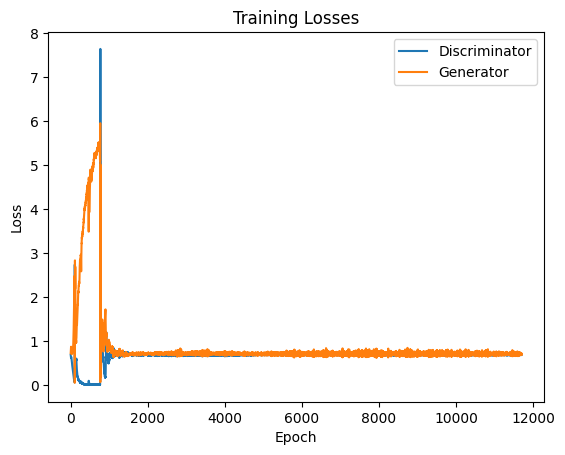

1/1 [==============================] - 0s 109ms/step


In [ ]:
batch_sizes_list=[64,128,256]
latent_dim=100
for batch_size in batch_sizes_list:
    # create the discriminator
    d_model = define_discriminator()
    # create the generator
    g_model = define_generator(latent_dim)
    # create the gan
    gan_model = define_gan(g_model, d_model)
    # load image data
    dataset = load_real_samples()
    # train model
    train(g_model, d_model, gan_model, dataset, latent_dim=100, n_epochs=50, n_batch=batch_size)
   # load model
    model = load_model('generator_model_050.h5')
# generate images
    latent_points = generate_latent_points(100, 25)
# generate images
    X = model.predict(latent_points)
# plot the result
    # save generated samples plot
    save_plot_perbatch(X,batch_size, 5)

#### Discriminator_without_dropout

In [ ]:
def define_discriminator_without_dropout(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow as tf
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
# Create a TensorFlow session
sess = tf.compat.v1.Session()

# Set the environment variables to use the GPU
physical_devices = tf.config.list_physical_devices('GPU')


In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model_without_dropout = define_discriminator_without_dropout()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model_without_dropout)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model_without_dropout, gan_model, dataset, latent_dim,n_batch=256)

In [ ]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


# def generate_latent_points(latent_dim, n_samples):
#     x_input = normal(0, 0.2, size=(n_samples, latent_dim))
#     return x_input


# create and save a plot of generated images (reversed grayscale)
def save_plot_eval(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

# # load model
model = load_model('generator_model_100.h5')
# # generate images
latent_points = generate_latent_points(100, 100)
# # generate images
X = model.predict(latent_points)
# # plot the result
save_plot_eval(X, 10)

In [ ]:
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
# load model
model = load_model('generator_model_100.h5')
# all 0s
vector = asarray([[0.0 for _ in range(100)]])
# generate image
X = model.predict(vector)
# plot the result
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()

OSError: ignored

### Change latent dim

In [ ]:
def save_plot1(examples, epoch, n):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename = 'results/generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

In [ ]:

%mkdir results

In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	# save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)

In [ ]:

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):

	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)


In [ ]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
latent_dim_list = [ 20,50, 100]
n_epochs = 50
n_batch = 256



# Loop over each value of latent_dim
for latent_dim in latent_dim_list:
    # create the discriminator
    d_model = define_discriminator()
    # create the generator
    g_model = define_generator(latent_dim)
    # create the gan
    gan_model = define_gan(g_model, d_model)
    # load image data
    dataset = load_real_samples()
    # train model
    train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch)
   # load model
    model = load_model('generator_model_050.h5')
# generate images
    latent_points = generate_latent_points(latent_dim, 25)
# generate images
    X = model.predict(latent_points)
# plot the result
    # save generated samples plot
    save_plot1(X, 100, 5)



/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


4/4 [==============================] - 0s 2ms/step
>1, 1/234, d=0.694, g=0.706
4/4 [==============================] - 0s 2ms/step
>1, 2/234, d=0.687, g=0.723
4/4 [==============================] - 0s 2ms/step
>1, 3/234, d=0.678, g=0.738
4/4 [==============================] - 0s 2ms/step
>1, 4/234, d=0.672, g=0.753
4/4 [==============================] - 0s 2ms/step
>1, 5/234, d=0.663, g=0.773
4/4 [==============================] - 0s 2ms/step
>1, 6/234, d=0.660, g=0.786
4/4 [==============================] - 0s 2ms/step
>1, 7/234, d=0.651, g=0.803
4/4 [==============================] - 0s 2ms/step
>1, 8/234, d=0.644, g=0.818
4/4 [==============================] - 0s 2ms/step
>1, 9/234, d=0.638, g=0.836
4/4 [==============================] - 0s 2ms/step
>1, 10/234, d=0.630, g=0.854
4/4 [==============================] - 0s 2ms/step
>1, 11/234, d=0.623, g=0.864
4/4 [==============================] - 0s 2ms/step
>1, 12/234, d=0.626, g=0.869
4/4 [==============================] - 0s 2ms/ste

>Accuracy real: 66%, fake: 49%
4/4 [==============================] - 0s 2ms/step
>11, 1/234, d=0.682, g=0.712
4/4 [==============================] - 0s 2ms/step
>11, 2/234, d=0.682, g=0.687
4/4 [==============================] - 0s 2ms/step
>11, 3/234, d=0.687, g=0.681
4/4 [==============================] - 0s 2ms/step
>11, 4/234, d=0.685, g=0.658
4/4 [==============================] - 0s 2ms/step
>11, 5/234, d=0.689, g=0.685
4/4 [==============================] - 0s 2ms/step
>11, 6/234, d=0.684, g=0.741
4/4 [==============================] - 0s 2ms/step
>11, 7/234, d=0.684, g=0.761
4/4 [==============================] - 0s 2ms/step
>11, 8/234, d=0.688, g=0.741
4/4 [==============================] - 0s 2ms/step
>11, 9/234, d=0.694, g=0.737
4/4 [==============================] - 0s 2ms/step
>11, 10/234, d=0.689, g=0.729
4/4 [==============================] - 0s 2ms/step
>11, 11/234, d=0.687, g=0.701
4/4 [==============================] - 0s 2ms/step
>11, 12/234, d=0.695, g=0.692
4/4 [=

>Accuracy real: 90%, fake: 35%
4/4 [==============================] - 0s 2ms/step
>21, 1/234, d=0.683, g=0.667
4/4 [==============================] - 0s 2ms/step
>21, 2/234, d=0.690, g=0.702
4/4 [==============================] - 0s 2ms/step
>21, 3/234, d=0.696, g=0.702
4/4 [==============================] - 0s 2ms/step
>21, 4/234, d=0.689, g=0.717
4/4 [==============================] - 0s 2ms/step
>21, 5/234, d=0.679, g=0.698
4/4 [==============================] - 0s 2ms/step
>21, 6/234, d=0.677, g=0.699
4/4 [==============================] - 0s 2ms/step
>21, 7/234, d=0.688, g=0.713
4/4 [==============================] - 0s 2ms/step
>21, 8/234, d=0.695, g=0.716
4/4 [==============================] - 0s 2ms/step
>21, 9/234, d=0.690, g=0.723
4/4 [==============================] - 0s 2ms/step
>21, 10/234, d=0.687, g=0.700
4/4 [==============================] - 0s 2ms/step
>21, 11/234, d=0.691, g=0.736
4/4 [==============================] - 0s 2ms/step
>21, 12/234, d=0.677, g=0.751
4/4 [=

>Accuracy real: 96%, fake: 13%
4/4 [==============================] - 0s 2ms/step
>31, 1/234, d=0.693, g=0.669
4/4 [==============================] - 0s 2ms/step
>31, 2/234, d=0.686, g=0.718
4/4 [==============================] - 0s 2ms/step
>31, 3/234, d=0.683, g=0.753
4/4 [==============================] - 0s 2ms/step
>31, 4/234, d=0.684, g=0.722
4/4 [==============================] - 0s 2ms/step
>31, 5/234, d=0.689, g=0.705
4/4 [==============================] - 0s 2ms/step
>31, 6/234, d=0.699, g=0.690
4/4 [==============================] - 0s 2ms/step
>31, 7/234, d=0.694, g=0.701
4/4 [==============================] - 0s 2ms/step
>31, 8/234, d=0.686, g=0.681
4/4 [==============================] - 0s 2ms/step
>31, 9/234, d=0.682, g=0.684
4/4 [==============================] - 0s 2ms/step
>31, 10/234, d=0.682, g=0.688
4/4 [==============================] - 0s 2ms/step
>31, 11/234, d=0.698, g=0.699
4/4 [==============================] - 0s 2ms/step
>31, 12/234, d=0.687, g=0.720
4/4 [=

>Accuracy real: 57%, fake: 77%
4/4 [==============================] - 0s 2ms/step
>41, 1/234, d=0.686, g=0.690
4/4 [==============================] - 0s 2ms/step
>41, 2/234, d=0.690, g=0.675
4/4 [==============================] - 0s 2ms/step
>41, 3/234, d=0.690, g=0.676
4/4 [==============================] - 0s 2ms/step
>41, 4/234, d=0.694, g=0.724
4/4 [==============================] - 0s 2ms/step
>41, 5/234, d=0.680, g=0.749
4/4 [==============================] - 0s 2ms/step
>41, 6/234, d=0.690, g=0.736
4/4 [==============================] - 0s 2ms/step
>41, 7/234, d=0.698, g=0.720
4/4 [==============================] - 0s 2ms/step
>41, 8/234, d=0.696, g=0.698
4/4 [==============================] - 0s 2ms/step
>41, 9/234, d=0.694, g=0.678
4/4 [==============================] - 0s 2ms/step
>41, 10/234, d=0.697, g=0.674
4/4 [==============================] - 0s 2ms/step
>41, 11/234, d=0.693, g=0.688
4/4 [==============================] - 0s 2ms/step
>41, 12/234, d=0.691, g=0.716
4/4 [=

4/4 [==============================] - 0s 2ms/step
>1, 1/234, d=0.693, g=0.707
4/4 [==============================] - 0s 2ms/step
>1, 2/234, d=0.686, g=0.733
4/4 [==============================] - 0s 2ms/step
>1, 3/234, d=0.680, g=0.752
4/4 [==============================] - 0s 2ms/step
>1, 4/234, d=0.672, g=0.774
4/4 [==============================] - 0s 2ms/step
>1, 5/234, d=0.660, g=0.792
4/4 [==============================] - 0s 2ms/step
>1, 6/234, d=0.659, g=0.812
4/4 [==============================] - 0s 2ms/step
>1, 7/234, d=0.648, g=0.830
4/4 [==============================] - 0s 2ms/step
>1, 8/234, d=0.643, g=0.852
4/4 [==============================] - 0s 2ms/step
>1, 9/234, d=0.637, g=0.868
4/4 [==============================] - 0s 2ms/step
>1, 10/234, d=0.630, g=0.878
4/4 [==============================] - 0s 2ms/step
>1, 11/234, d=0.627, g=0.883
4/4 [==============================] - 0s 2ms/step
>1, 12/234, d=0.629, g=0.881
4/4 [==============================] - 0s 2ms/ste

>Accuracy real: 66%, fake: 36%
4/4 [==============================] - 0s 2ms/step
>11, 1/234, d=0.687, g=0.701
4/4 [==============================] - 0s 2ms/step
>11, 2/234, d=0.694, g=0.724
4/4 [==============================] - 0s 2ms/step
>11, 3/234, d=0.695, g=0.740
4/4 [==============================] - 0s 2ms/step
>11, 4/234, d=0.692, g=0.742
4/4 [==============================] - 0s 2ms/step
>11, 5/234, d=0.692, g=0.727
4/4 [==============================] - 0s 2ms/step
>11, 6/234, d=0.685, g=0.712
4/4 [==============================] - 0s 2ms/step
>11, 7/234, d=0.691, g=0.707
4/4 [==============================] - 0s 2ms/step
>11, 8/234, d=0.684, g=0.701
4/4 [==============================] - 0s 2ms/step
>11, 9/234, d=0.682, g=0.700
4/4 [==============================] - 0s 2ms/step
>11, 10/234, d=0.684, g=0.707
4/4 [==============================] - 0s 2ms/step
>11, 11/234, d=0.680, g=0.722
4/4 [==============================] - 0s 2ms/step
>11, 12/234, d=0.676, g=0.722
4/4 [=

>Accuracy real: 71%, fake: 59%
4/4 [==============================] - 0s 2ms/step
>21, 1/234, d=0.686, g=0.721
4/4 [==============================] - 0s 2ms/step
>21, 2/234, d=0.679, g=0.743
4/4 [==============================] - 0s 2ms/step
>21, 3/234, d=0.680, g=0.752
4/4 [==============================] - 0s 2ms/step
>21, 4/234, d=0.686, g=0.730
4/4 [==============================] - 0s 2ms/step
>21, 5/234, d=0.686, g=0.693
4/4 [==============================] - 0s 2ms/step
>21, 6/234, d=0.687, g=0.678
4/4 [==============================] - 0s 2ms/step
>21, 7/234, d=0.689, g=0.668
4/4 [==============================] - 0s 2ms/step
>21, 8/234, d=0.689, g=0.688
4/4 [==============================] - 0s 2ms/step
>21, 9/234, d=0.686, g=0.713
4/4 [==============================] - 0s 2ms/step
>21, 10/234, d=0.682, g=0.740
4/4 [==============================] - 0s 2ms/step
>21, 11/234, d=0.685, g=0.739
4/4 [==============================] - 0s 2ms/step
>21, 12/234, d=0.683, g=0.728
4/4 [=

>Accuracy real: 13%, fake: 97%
4/4 [==============================] - 0s 2ms/step
>31, 1/234, d=0.697, g=0.682
4/4 [==============================] - 0s 2ms/step
>31, 2/234, d=0.682, g=0.659
4/4 [==============================] - 0s 2ms/step
>31, 3/234, d=0.692, g=0.675
4/4 [==============================] - 0s 2ms/step
>31, 4/234, d=0.687, g=0.736
4/4 [==============================] - 0s 2ms/step
>31, 5/234, d=0.692, g=0.730
4/4 [==============================] - 0s 2ms/step
>31, 6/234, d=0.685, g=0.684
4/4 [==============================] - 0s 2ms/step
>31, 7/234, d=0.689, g=0.678
4/4 [==============================] - 0s 2ms/step
>31, 8/234, d=0.702, g=0.731
4/4 [==============================] - 0s 2ms/step
>31, 9/234, d=0.688, g=0.762
4/4 [==============================] - 0s 2ms/step
>31, 10/234, d=0.684, g=0.770
4/4 [==============================] - 0s 2ms/step
>31, 11/234, d=0.689, g=0.721
4/4 [==============================] - 0s 2ms/step
>31, 12/234, d=0.689, g=0.697
4/4 [=

>Accuracy real: 100%, fake: 6%
4/4 [==============================] - 0s 2ms/step
>41, 1/234, d=0.680, g=0.681
4/4 [==============================] - 0s 2ms/step
>41, 2/234, d=0.686, g=0.725
4/4 [==============================] - 0s 2ms/step
>41, 3/234, d=0.690, g=0.729
4/4 [==============================] - 0s 2ms/step
>41, 4/234, d=0.683, g=0.701
4/4 [==============================] - 0s 2ms/step
>41, 5/234, d=0.680, g=0.698
4/4 [==============================] - 0s 2ms/step
>41, 6/234, d=0.688, g=0.727
4/4 [==============================] - 0s 2ms/step
>41, 7/234, d=0.689, g=0.734
4/4 [==============================] - 0s 2ms/step
>41, 8/234, d=0.685, g=0.725
4/4 [==============================] - 0s 2ms/step
>41, 9/234, d=0.689, g=0.686
4/4 [==============================] - 0s 2ms/step
>41, 10/234, d=0.680, g=0.700
4/4 [==============================] - 0s 2ms/step
>41, 11/234, d=0.691, g=0.713
4/4 [==============================] - 0s 2ms/step
>41, 12/234, d=0.682, g=0.700
4/4 [=

>Accuracy real: 74%, fake: 45%


4/4 [==============================] - 0s 2ms/step
>1, 1/234, d=0.692, g=0.720
4/4 [==============================] - 0s 2ms/step
>1, 2/234, d=0.682, g=0.733
4/4 [==============================] - 0s 2ms/step
>1, 3/234, d=0.675, g=0.754
4/4 [==============================] - 0s 2ms/step
>1, 4/234, d=0.668, g=0.775
4/4 [==============================] - 0s 2ms/step
>1, 5/234, d=0.658, g=0.795
4/4 [==============================] - 0s 2ms/step
>1, 6/234, d=0.653, g=0.807
4/4 [==============================] - 0s 2ms/step
>1, 7/234, d=0.648, g=0.825
4/4 [==============================] - 0s 2ms/step
>1, 8/234, d=0.640, g=0.834
4/4 [==============================] - 0s 2ms/step
>1, 9/234, d=0.637, g=0.838
4/4 [==============================] - 0s 2ms/step
>1, 10/234, d=0.639, g=0.834
4/4 [==============================] - 0s 2ms/step
>1, 11/234, d=0.638, g=0.823
4/4 [==============================] - 0s 2ms/step
>1, 12/234, d=0.640, g=0.799
4/4 [==============================] - 0s 2ms/ste

>Accuracy real: 90%, fake: 52%
4/4 [==============================] - 0s 2ms/step
>11, 1/234, d=0.672, g=0.710
4/4 [==============================] - 0s 2ms/step
>11, 2/234, d=0.677, g=0.714
4/4 [==============================] - 0s 2ms/step
>11, 3/234, d=0.674, g=0.717
4/4 [==============================] - 0s 2ms/step
>11, 4/234, d=0.671, g=0.720
4/4 [==============================] - 0s 2ms/step
>11, 5/234, d=0.677, g=0.717
4/4 [==============================] - 0s 2ms/step
>11, 6/234, d=0.679, g=0.719
4/4 [==============================] - 0s 2ms/step
>11, 7/234, d=0.674, g=0.723
4/4 [==============================] - 0s 2ms/step
>11, 8/234, d=0.675, g=0.717
4/4 [==============================] - 0s 2ms/step
>11, 9/234, d=0.679, g=0.720
4/4 [==============================] - 0s 2ms/step
>11, 10/234, d=0.676, g=0.710
4/4 [==============================] - 0s 2ms/step
>11, 11/234, d=0.677, g=0.712
4/4 [==============================] - 0s 2ms/step
>11, 12/234, d=0.677, g=0.707
4/4 [=

>Accuracy real: 24%, fake: 95%
4/4 [==============================] - 0s 2ms/step
>21, 1/234, d=0.685, g=0.702
4/4 [==============================] - 0s 2ms/step
>21, 2/234, d=0.689, g=0.681
4/4 [==============================] - 0s 2ms/step
>21, 3/234, d=0.682, g=0.686
4/4 [==============================] - 0s 2ms/step
>21, 4/234, d=0.686, g=0.713
4/4 [==============================] - 0s 3ms/step
>21, 5/234, d=0.694, g=0.738
4/4 [==============================] - 0s 2ms/step
>21, 6/234, d=0.692, g=0.716
4/4 [==============================] - 0s 2ms/step
>21, 7/234, d=0.683, g=0.696
4/4 [==============================] - 0s 2ms/step
>21, 8/234, d=0.689, g=0.693
4/4 [==============================] - 0s 2ms/step
>21, 9/234, d=0.686, g=0.693
4/4 [==============================] - 0s 2ms/step
>21, 10/234, d=0.681, g=0.701
4/4 [==============================] - 0s 2ms/step
>21, 11/234, d=0.684, g=0.709
4/4 [==============================] - 0s 2ms/step
>21, 12/234, d=0.685, g=0.717
4/4 [=

>Accuracy real: 65%, fake: 74%
4/4 [==============================] - 0s 3ms/step
>31, 1/234, d=0.683, g=0.707
4/4 [==============================] - 0s 3ms/step
>31, 2/234, d=0.697, g=0.708
4/4 [==============================] - 0s 2ms/step
>31, 3/234, d=0.688, g=0.691
4/4 [==============================] - 0s 2ms/step
>31, 4/234, d=0.687, g=0.714
4/4 [==============================] - 0s 2ms/step
>31, 5/234, d=0.681, g=0.714
4/4 [==============================] - 0s 2ms/step
>31, 6/234, d=0.689, g=0.709
4/4 [==============================] - 0s 2ms/step
>31, 7/234, d=0.695, g=0.704
4/4 [==============================] - 0s 2ms/step
>31, 8/234, d=0.686, g=0.690
4/4 [==============================] - 0s 2ms/step
>31, 9/234, d=0.698, g=0.711
4/4 [==============================] - 0s 2ms/step
>31, 10/234, d=0.684, g=0.742
4/4 [==============================] - 0s 2ms/step
>31, 11/234, d=0.688, g=0.743
4/4 [==============================] - 0s 2ms/step
>31, 12/234, d=0.690, g=0.689
4/4 [=

>Accuracy real: 51%, fake: 80%
4/4 [==============================] - 0s 2ms/step
>41, 1/234, d=0.689, g=0.708
4/4 [==============================] - 0s 2ms/step
>41, 2/234, d=0.694, g=0.738
4/4 [==============================] - 0s 2ms/step
>41, 3/234, d=0.679, g=0.703
4/4 [==============================] - 0s 2ms/step
>41, 4/234, d=0.682, g=0.674
4/4 [==============================] - 0s 2ms/step
>41, 5/234, d=0.690, g=0.693
4/4 [==============================] - 0s 2ms/step
>41, 6/234, d=0.688, g=0.708
4/4 [==============================] - 0s 2ms/step
>41, 7/234, d=0.687, g=0.730
4/4 [==============================] - 0s 2ms/step
>41, 8/234, d=0.693, g=0.727
4/4 [==============================] - 0s 2ms/step
>41, 9/234, d=0.677, g=0.714
4/4 [==============================] - 0s 2ms/step
>41, 10/234, d=0.684, g=0.720
4/4 [==============================] - 0s 2ms/step
>41, 11/234, d=0.688, g=0.704
4/4 [==============================] - 0s 2ms/step
>41, 12/234, d=0.685, g=0.721
4/4 [=

>Accuracy real: 50%, fake: 86%
1/1 [==============================] - 0s 91ms/step


### Change the activation function

#### Sigmoid activation function

In [ ]:
# define discriminator
from keras.layers import Dense, Activation

def define_discriminator( activation='sigmoid'):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    if activation == 'leakyrelu':
        model.add(LeakyReLU(alpha=0.2))
    else:
        model.add(Activation(activation))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    if activation == 'leakyrelu':
        model.add(LeakyReLU(alpha=0.2))
    else:
        model.add(Activation(activation))
    model.add(Flatten())
    model.add(Dense(128))
    if activation == 'leakyrelu':
        model.add(LeakyReLU(alpha=0.2))
    else:
        model.add(Activation(activation))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define generator
def define_generator(latent_dim, activation='sigmoid'):
    model = Sequential()
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    if activation == 'leakyrelu':
        model.add(LeakyReLU(alpha=0.2))
    else:
        model.add(Activation(activation))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    if activation == 'leakyrelu':
        model.add(LeakyReLU(alpha=0.2))
    else:
        model.add(Activation(activation))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    if activation == 'leakyrelu':
        model.add(LeakyReLU(alpha=0.2))
    else:
        model.add(Activation(activation))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model


In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model_with_sig_activation= define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model_with_sig_activation)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model_with_sig_activation, gan_model, dataset, latent_dim,n_batch=256)

4/4 [==============================] - 0s 2ms/step
>1, 1/234, d=0.736, g=0.496
4/4 [==============================] - 0s 2ms/step
>1, 2/234, d=0.718, g=0.582
4/4 [==============================] - 0s 2ms/step
>1, 3/234, d=0.701, g=0.782
4/4 [==============================] - 0s 2ms/step
>1, 4/234, d=0.698, g=0.771
4/4 [==============================] - 0s 2ms/step
>1, 5/234, d=0.697, g=0.656
4/4 [==============================] - 0s 2ms/step
>1, 6/234, d=0.694, g=0.653
4/4 [==============================] - 0s 2ms/step
>1, 7/234, d=0.694, g=0.717
4/4 [==============================] - 0s 2ms/step
>1, 8/234, d=0.693, g=0.711
4/4 [==============================] - 0s 2ms/step
>1, 9/234, d=0.693, g=0.676
4/4 [==============================] - 0s 2ms/step
>1, 10/234, d=0.693, g=0.691
4/4 [==============================] - 0s 2ms/step
>1, 11/234, d=0.693, g=0.704
4/4 [==============================] - 0s 2ms/step
>1, 12/234, d=0.693, g=0.689
4/4 [==============================] - 0s 2ms/ste

4/4 [==============================] - 0s 2ms/step
>11, 1/234, d=0.000, g=7.666
4/4 [==============================] - 0s 2ms/step
>11, 2/234, d=0.000, g=7.702
4/4 [==============================] - 0s 2ms/step
>11, 3/234, d=0.001, g=7.678
4/4 [==============================] - 0s 2ms/step
>11, 4/234, d=0.001, g=7.609
4/4 [==============================] - 0s 2ms/step
>11, 5/234, d=0.000, g=7.603
4/4 [==============================] - 0s 2ms/step
>11, 6/234, d=0.000, g=7.636
4/4 [==============================] - 0s 2ms/step
>11, 7/234, d=0.000, g=7.667
4/4 [==============================] - 0s 2ms/step
>11, 8/234, d=0.000, g=7.679
4/4 [==============================] - 0s 2ms/step
>11, 9/234, d=0.000, g=7.708
4/4 [==============================] - 0s 2ms/step
>11, 10/234, d=0.000, g=7.751
4/4 [==============================] - 0s 2ms/step
>11, 11/234, d=0.000, g=7.791
4/4 [==============================] - 0s 2ms/step
>11, 12/234, d=0.000, g=7.802
4/4 [==============================] 

4/4 [==============================] - 0s 2ms/step
>21, 1/234, d=0.000, g=10.714
4/4 [==============================] - 0s 2ms/step
>21, 2/234, d=0.001, g=10.414
4/4 [==============================] - 0s 2ms/step
>21, 3/234, d=0.000, g=10.124
4/4 [==============================] - 0s 2ms/step
>21, 4/234, d=0.000, g=9.939
4/4 [==============================] - 0s 2ms/step
>21, 5/234, d=0.000, g=9.832
4/4 [==============================] - 0s 2ms/step
>21, 6/234, d=0.000, g=9.775
4/4 [==============================] - 0s 2ms/step
>21, 7/234, d=0.000, g=9.748
4/4 [==============================] - 0s 2ms/step
>21, 8/234, d=0.000, g=9.737
4/4 [==============================] - 0s 2ms/step
>21, 9/234, d=0.000, g=9.735
4/4 [==============================] - 0s 2ms/step
>21, 10/234, d=0.000, g=9.735
4/4 [==============================] - 0s 2ms/step
>21, 11/234, d=0.000, g=9.710
4/4 [==============================] - 0s 2ms/step
>21, 12/234, d=0.000, g=9.697
4/4 [=============================

4/4 [==============================] - 0s 2ms/step
>31, 1/234, d=0.000, g=10.860
4/4 [==============================] - 0s 2ms/step
>31, 2/234, d=0.000, g=10.855
4/4 [==============================] - 0s 2ms/step
>31, 3/234, d=0.000, g=10.848
4/4 [==============================] - 0s 2ms/step
>31, 4/234, d=0.000, g=10.853
4/4 [==============================] - 0s 2ms/step
>31, 5/234, d=0.000, g=10.857
4/4 [==============================] - 0s 2ms/step
>31, 6/234, d=0.000, g=10.862
4/4 [==============================] - 0s 2ms/step
>31, 7/234, d=0.000, g=10.815
4/4 [==============================] - 0s 2ms/step
>31, 8/234, d=0.000, g=10.796
4/4 [==============================] - 0s 2ms/step
>31, 9/234, d=0.000, g=10.789
4/4 [==============================] - 0s 2ms/step
>31, 10/234, d=0.000, g=10.750
4/4 [==============================] - 0s 2ms/step
>31, 11/234, d=0.000, g=10.734
4/4 [==============================] - 0s 2ms/step
>31, 12/234, d=0.000, g=10.734
4/4 [====================

KeyboardInterrupt: ignored

In [ ]:
# load model
model = load_model('generator_model_100.h5')
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 5)

### Change the loss

In [ ]:
from keras.losses import MeanSquaredError

In [ ]:
# define the standalone discriminator model
def define_discriminator_mse(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=MeanSquaredError(), optimizer=opt, metrics=['accuracy'])
	return model

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan_mse(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=MeanSquaredError(), optimizer=opt)
	return model

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model_with_mse= define_discriminator_mse()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model_mse = define_gan_mse(g_model, d_model_with_mse)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model_with_mse, gan_model_mse, dataset, latent_dim,n_batch=256)

4/4 [==============================] - 0s 2ms/step
>1, 1/234, d=0.242, g=0.295
4/4 [==============================] - 0s 2ms/step
>1, 2/234, d=0.241, g=0.293
4/4 [==============================] - 0s 2ms/step
>1, 3/234, d=0.245, g=0.281
4/4 [==============================] - 0s 2ms/step
>1, 4/234, d=0.249, g=0.271
4/4 [==============================] - 0s 2ms/step
>1, 5/234, d=0.250, g=0.264
4/4 [==============================] - 0s 2ms/step
>1, 6/234, d=0.250, g=0.259
4/4 [==============================] - 0s 2ms/step
>1, 7/234, d=0.249, g=0.257
4/4 [==============================] - 0s 2ms/step
>1, 8/234, d=0.248, g=0.256
4/4 [==============================] - 0s 2ms/step
>1, 9/234, d=0.248, g=0.255
4/4 [==============================] - 0s 2ms/step
>1, 10/234, d=0.246, g=0.255
4/4 [==============================] - 0s 2ms/step
>1, 11/234, d=0.243, g=0.254
4/4 [==============================] - 0s 2ms/step
>1, 12/234, d=0.239, g=0.254
4/4 [==============================] - 0s 2ms/ste

KeyboardInterrupt: ignored

In [ ]:
# load model
model = load_model('generator_model_100.h5')
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 5)

#GANS CIPHAR10

In [ ]:
from numpy import random
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

from matplotlib import pyplot as plt


In [ ]:

(trainX, trainy), (testX, testy) = load_data()

# plot 25 images
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i])
plt.show()


In [ ]:

def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()

	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) #16x16x128
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) #8x8x128
	model.add(LeakyReLU(alpha=0.2))

	model.add(Flatten()) #shape of 8192
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid')) #shape of 1
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

test_discr = define_discriminator()
print(test_discr.summary())

In [ ]:
def define_generator(latent_dim):
	model = Sequential()

	n_nodes = 128 * 8 * 8  #8192 nodes
	model.add(Dense(n_nodes, input_dim=latent_dim)) #Dense layer so we can work with 1D latent vector
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 128)))  #8x8x128 dataset from the latent vector.
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #16x16x128
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
	model.add(LeakyReLU(alpha=0.2))
	# generate
	model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #32x32x3
	return model
test_gen = define_generator(100)
print(test_gen.summary())



In [ ]:
def define_gan(generator, discriminator):
	discriminator.trainable = False
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
def load_real_samples():
	(trainX, _), (_, _) = load_data()
	# cConvert to float and scale.
	X = trainX.astype('float32')
	X = (X - 127.5) / 127.5
	return X

In [ ]:
def generate_real_samples(dataset, n_samples):

	ix = randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = ones((n_samples, 1))
	return X, y
# def generate_latent_points(latent_dim, n_samples):
# 	x_input = randn(latent_dim * n_samples)
# 	x_input = x_input.reshape(n_samples, latent_dim)
# 	return x_input
def generate_latent_points(latent_dim, n_samples):
    x_input = random.normal(0, 0.2, size=(n_samples, latent_dim))
    return x_input

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples)
	X = generator.predict(x_input)
	y = zeros((n_samples, 1))
	return X, y

In [ ]:


def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):

			X_real, y_real = generate_real_samples(dataset, half_batch)

			d_loss_real, _ = d_model.train_on_batch(X_real, y_real)

            # generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)


			X_gan = generate_latent_points(latent_dim, n_batch)


			y_gan = ones((n_batch, 1))


			g_loss = gan_model.train_on_batch(X_gan, y_gan)

            # Print losses on this batch
			print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
	# save the generator model
	g_model.save('cifar_generator_100epochs.h5')


latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=100)

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss_real, _ = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # Print losses on this batch
            print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))

        # Save the generator model every 20 epochs
        if (i+1) % 20 == 0:
            g_model.save(f'cifar_generator_{i+1}epochs.h5')


In [ ]:

model = load_model('cifar_generator_20epochs.h5') #Model trained for 20 epochs
# generate images
latent_points = generate_latent_points(100, 25)
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

import numpy as np
X = (X*255).astype(np.uint8)
# Plot generated images
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()
# plot the result
show_plot(X, 5)

In [ ]:




from keras.models import load_model
from numpy.random import randn


model = load_model('cifar_generator_40epochs.h5') #Model trained for 40 epochs
# generate images
latent_points = generate_latent_points(100, 25)
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

import numpy as np
X = (X*255).astype(np.uint8)
# Plot generated images
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()
# plot the result
show_plot(X, 5)

In [ ]:
model = load_model('cifar_generator_60epochs.h5') #Model trained for 60 epochs
# generate images
latent_points = generate_latent_points(100, 25)
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

import numpy as np
X = (X*255).astype(np.uint8)
# Plot generated images
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()
# plot the result
show_plot(X, 5)

In [ ]:
model = load_model('cifar_generator_80epochs.h5') #Model trained for 80 epochs
# generate images
latent_points = generate_latent_points(100, 25)
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

import numpy as np
X = (X*255).astype(np.uint8)
# Plot generated images
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()
# plot the result
show_plot(X, 5)

In [ ]:
model = load_model('cifar_generator_100epochs.h5') #Model trained for 100 epochs
# generate images
latent_points = generate_latent_points(100, 25)
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

import numpy as np
X = (X*255).astype(np.uint8)
# Plot generated images
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()
# plot the result
show_plot(X, 5)